# Idealized Sensitivity Study

Throughout this document *unmodified* is unsed to describe the runs which used the original values of `LANDUSE.TBL`.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter
from netCDF4 import Dataset
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords, g_geoht, combine_files, ALL_TIMES)

# Suppress warnings so the notebook looks nice
import warnings
warnings.filterwarnings('ignore')
# Style for plotting
plt.style.use('default')

# N-ICE Measurements
## NOTE: SEB Measurements are in UTC
### Importing SEB dataset
Measurements_seb = xr.open_dataset('/Users/sarahymurphy/Library/Mobile Documents/com~apple~CloudDocs/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', decode_times = False)

### Longwave radiation into dataframes
M_downlw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_longwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw']).resample('1h').mean()
M_uplw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_longwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw']).resample('1h').mean()

### Shortwave radiation into dataframes
M_downsw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_shortwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw']).resample('1h').mean()
M_upsw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_shortwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw']).resample('1h').mean()

###  Calculating net radiation
M_net = (M_downlw['lw'] - M_uplw['lw']) + (M_downsw['sw'] - M_upsw['sw'])

### Sensible and latent heat flux into dataframes
M_lat = -pd.DataFrame(Measurements_seb.variables['surface_downward_latent_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lh']).resample('1h').mean()
M_sen = -pd.DataFrame(Measurements_seb.variables['surface_downward_sensible_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sh']).resample('1h').mean()
## NOTE: sensible and latent heat flux negative to match WRF sign convention

### Temperature 
T_meas = pd.read_excel('/Users/sarahymurphy/Library/Mobile Documents/com~apple~CloudDocs/all_datasets/nice_published_datasets/Ts.xlsx', index_col = 0).resample('1h').mean()

## Soundings
MeasSoundings = xr.open_dataset('/Users/sarahymurphy/Library/Mobile Documents/com~apple~CloudDocs/all_datasets/nice_published_datasets/rsData_gridded.nc')
MeasSoundings_Times = pd.read_fwf('/Users/sarahymurphy/Library/Mobile Documents/com~apple~CloudDocs/all_datasets/nice_published_datasets/rsData_gridded_dates.txt', header = None)

MeasSoundings_Times.columns = ['year','month','day','hour','minute','second']
MeasSoundings_Times.index = pd.to_datetime(MeasSoundings_Times[['year', 'month', 'day', 'hour', 'minute', 'second']])

sounding_t = pd.DataFrame(MeasSoundings['temp'].values, index = MeasSoundings_Times.index, columns = MeasSoundings['height'].values)

sounding_ws = pd.DataFrame(MeasSoundings['ws'].values, index = MeasSoundings_Times.index, columns = MeasSoundings['height'].values)


sfc_relative_humidity = pd.DataFrame(MeasSoundings['rh'].values, 
                           index = MeasSoundings_Times.index, 
                           columns = MeasSoundings['height'].astype(str)).resample('1h').mean()

sfc_wind_direction = pd.DataFrame(MeasSoundings['wd'].values, 
                           index = MeasSoundings_Times.index, 
                           columns = MeasSoundings['height'].astype(str)).resample('1h').mean()

sfc_wind_speed = pd.DataFrame(MeasSoundings['ws'].values, 
                           index = MeasSoundings_Times.index, 
                           columns = MeasSoundings['height'].astype(str)).resample('1h').mean()

sfc_temperature = pd.DataFrame(MeasSoundings['temp'].values + 273.15, 
                                index = MeasSoundings_Times.index, 
                                columns = MeasSoundings['height'].astype(str)).resample('1h').mean()

sfc_pressure = pd.DataFrame(MeasSoundings['press'].values, 
                             index = MeasSoundings_Times.index, 
                             columns = MeasSoundings['height'].astype(str)).resample('1h').mean()


# Height above sea level (m)
sfc_height = sfc_relative_humidity.index.values

# Potential temperature (k)
k = 2/7 # constent for potential temperature equation
sfc_potential_temperature = sfc_temperature * (1000 / sfc_pressure) ** k

# Mixing ratio (g/kg)
# Using Clasius Clapperyon

# Saturation vapor pressure #hPa
sfc_saturation_vapor_pressure = 6.112 * np.exp(((17.67 * (sfc_temperature - 273.15)) / ((sfc_temperature - 273.15) + 243.5)))

# Vapor pressure
sfc_vapor_pressure = sfc_saturation_vapor_pressure * (sfc_relative_humidity / 100)

# Mixing ratio g/kg
sfc_mixing_ratio = 621.97 * (sfc_vapor_pressure / ((sfc_pressure) - sfc_vapor_pressure))
sfc_mixing_ratio.index = sfc_mixing_ratio.index.to_pydatetime()

# Set date format for plots throughout the notebook
myFmt = DateFormatter("%m/%d \n %H:%M:%S")


# Case 1 - Winter Clear

In [2]:
fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case1/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
# Defining start and end dates of case study
sdate = '2015-02-04'
edate = '2015-02-06' 

sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

#cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
#cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values).resample('1h').mean()

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values).resample('1h').mean()

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values).resample('1h').mean()

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values).resample('1h').mean()

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values).resample('1h').mean()

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values).resample('1h').mean()

# Finding all wrfout file
fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/1ClearWinter_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

#cldfra_mod = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
#cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod)

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values).resample('1h').mean()

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values).resample('1h').mean()

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values).resample('1h').mean()

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values).resample('1h').mean()

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values).resample('1h').mean()

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values).resample('1h').mean()

In [3]:
wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case1/000101/wrfstat_d01_2015-02-04_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]

qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df = np.sqrt(v_df**2 + u_df**2)
qv_df = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/1ClearWinter_000101/wrfstat_d01_2015-02-04_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]

qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df_mod = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df_mod = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df_mod = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df_mod = np.sqrt(v_df_mod**2 + u_df_mod**2)
qv_df_mod = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df_mod = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

## Clouds

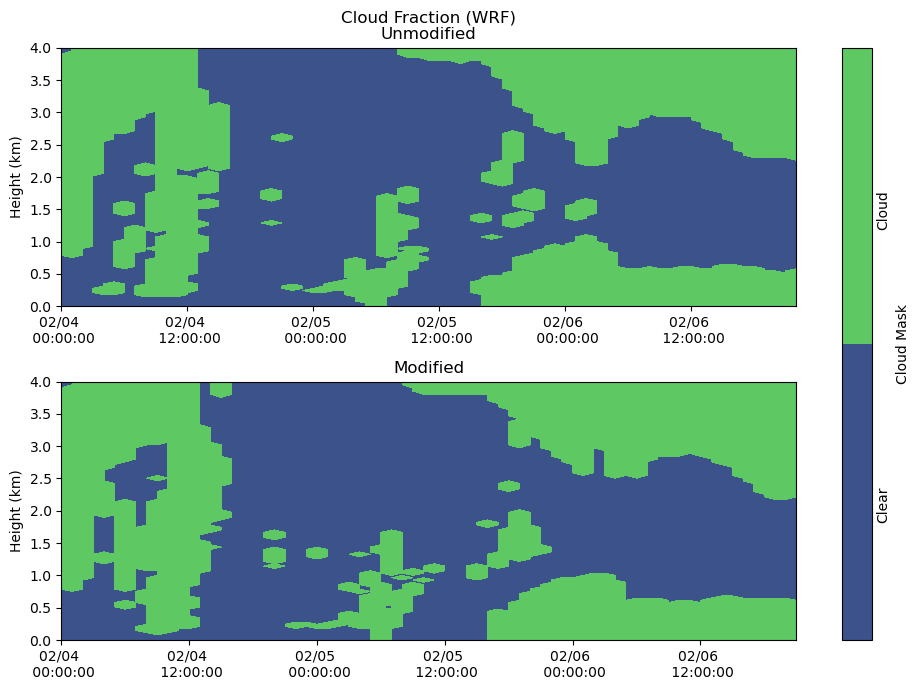

In [4]:
fig, axs = plt.subplots(2, figsize=(10,7))

heatmap = axs[0].contourf(cloudmask_df.index, cloudmask_df.columns / 1000, cloudmask_df.T.values, levels = [-1, 0, 1])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,4)

heatmap = axs[1].contourf(cloudmask_df_mod.index, cloudmask_df_mod.columns / 1000, cloudmask_df_mod.T, levels = [-1, 0, 1])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,4)
plt.tight_layout()

cbar = fig.colorbar(heatmap, ax=axs[:], ticks = [-0.5, 0.5], label = "Cloud Mask")
cbar.ax.set_yticklabels(['Clear','Cloud'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.show()

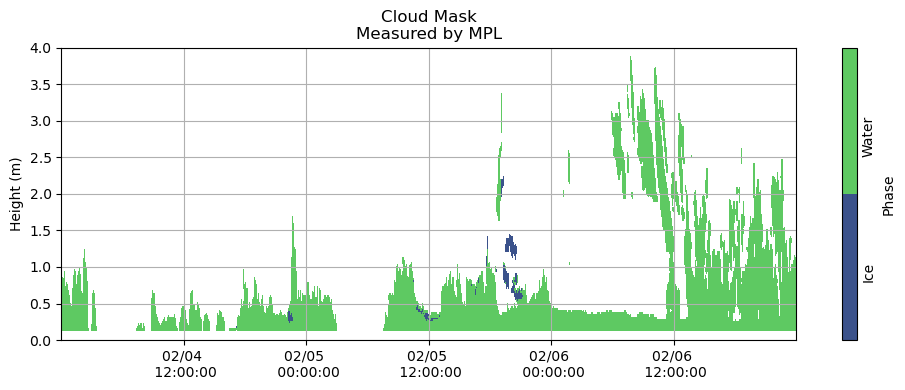

In [5]:
fns = ['/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150204.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150205.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150206.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns / 1000, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (m)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


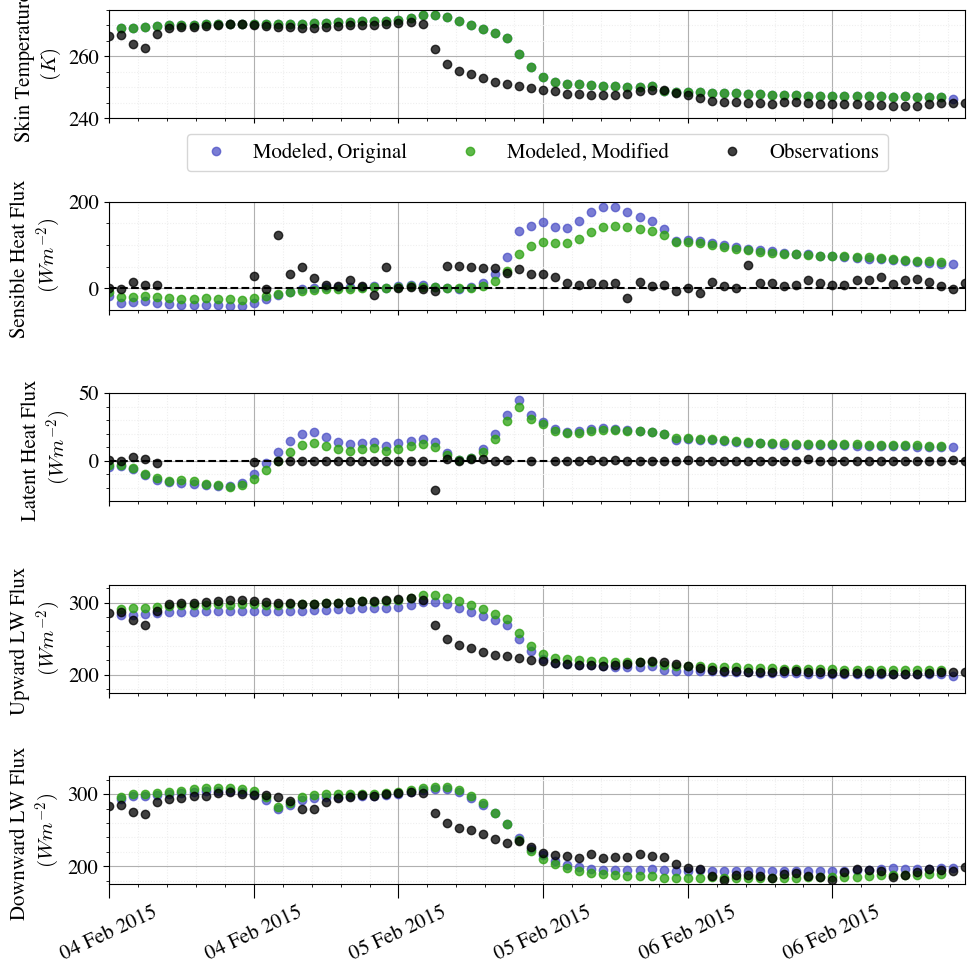

In [6]:
%pylab inline

mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'times'
mpl.rcParams["mathtext.fontset"] = 'cm'

plt.figure(figsize = (10,10))
plt.subplot(511)
plt.plot(tsk_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(tsk_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.75, color = 'k')
plt.ylabel('Skin Temperature \n$(K)$')
plt.grid()
plt.legend(['Modeled, Original', 'Modeled, Modified', 'Observations'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.ylim(240,275)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(512)
plt.plot(sh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(sh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Sensible Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-50,200)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(513)
plt.plot(lh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Latent Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-30,50)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(514)
plt.plot(lwupb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwupb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_uplw[sdate:edate].index[0], xmax = M_uplw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Upward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(175,325)
plt.xlim(M_uplw[sdate:edate].index[0],M_uplw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(515)
plt.plot(lwdnb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_downlw[sdate:edate].index[0], xmax = M_downlw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Downward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(175,325)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.tight_layout()
myFmt = DateFormatter("%d %b %Y")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gca().tick_params(axis = 'x', labelrotation = 25, length = 10, labelsize = 15)
plt.gca().tick_params(axis = 'y', length = 4, labelsize = 15)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('case1_all_new.png')

## Longwave Radiation

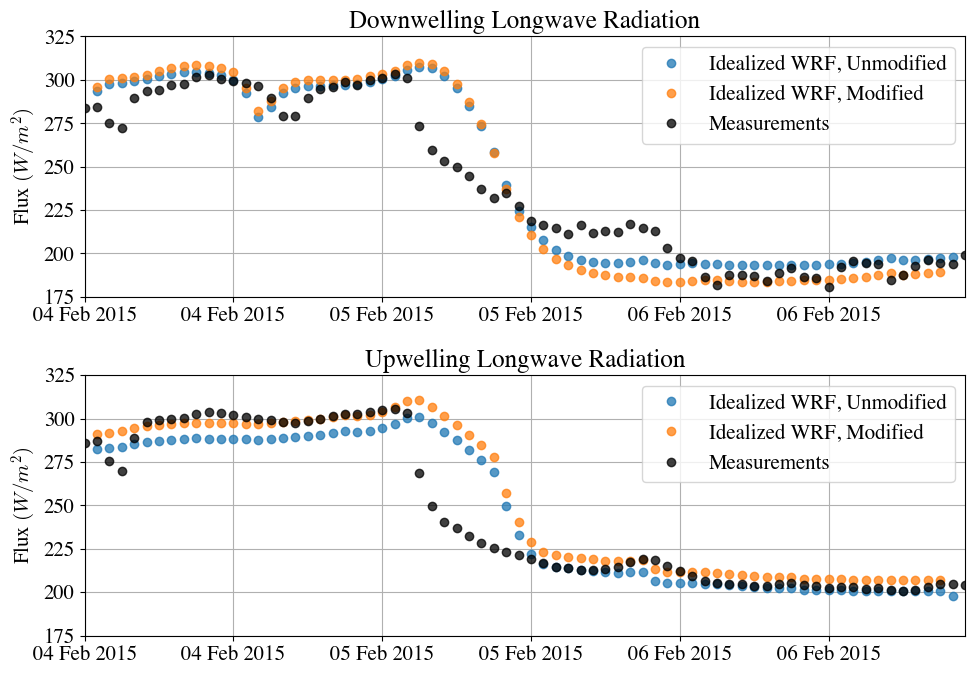

In [7]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(175,325)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(175,325)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Wind Speed

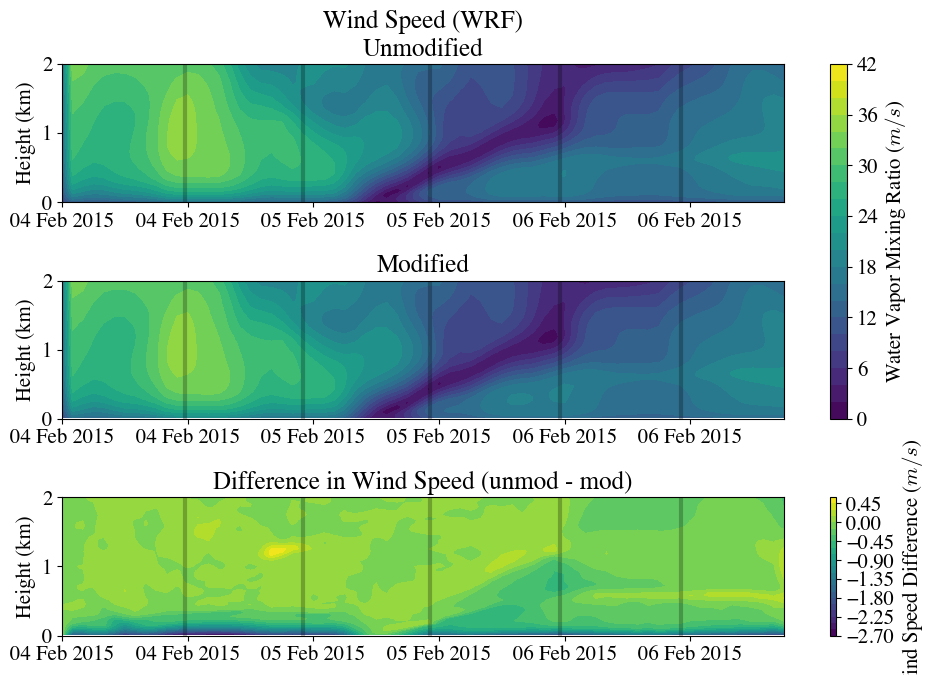

In [8]:
fig, axs = plt.subplots(3, figsize=(10,7))

heatmap = axs[0].contourf(ws_df_mod.index, ws_df.columns / 1000, ws_df.T.values[:,:-1], levels = 20)
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Wind Speed (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,2)
axs[0].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap = axs[1].contourf(ws_df_mod.index, ws_df_mod.columns / 1000, ws_df_mod.T.values, levels = 20)
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,2)
axs[1].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap_1 = axs[2].contourf(ws_df_mod.index, ws_df.columns / 1000, ws_df.T.values[:,:-1] - ws_df_mod.T.values, levels = 20)
axs[2].set_ylabel('Height (km)')
axs[2].set_title('Difference in Wind Speed (unmod - mod)')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_ylim(0,2)
axs[2].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[0:2])
cbar.set_label('Water Vapor Mixing Ratio ($m/s$)')

cbar = fig.colorbar(heatmap_1, ax=axs[2])
cbar.set_label('Wind Speed Difference ($m/s$)')

plt.show()

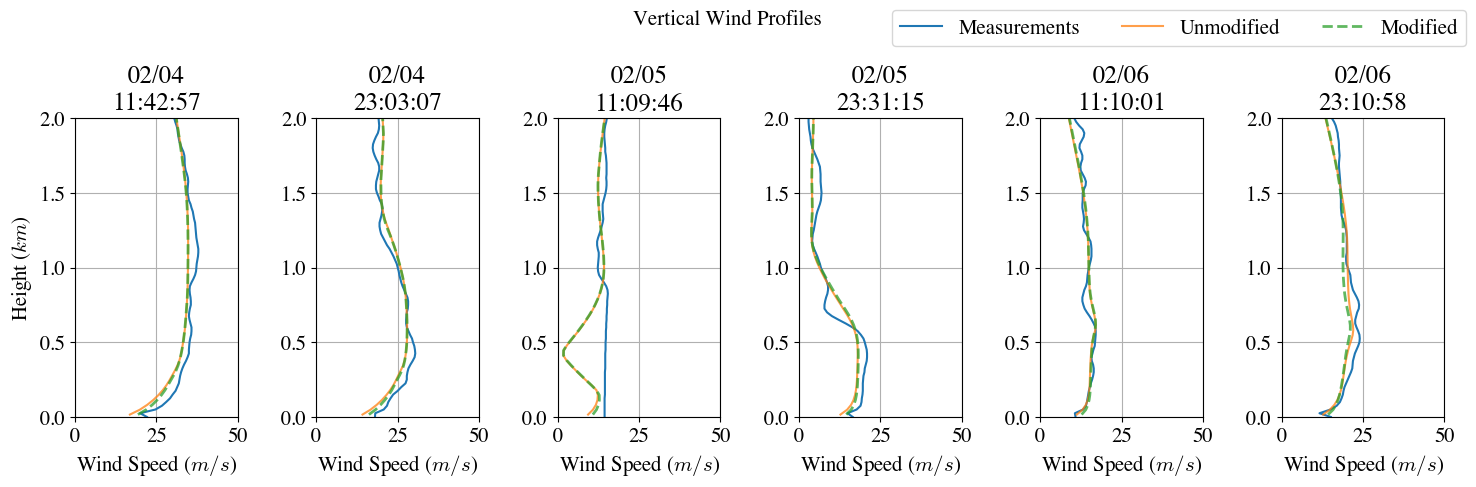

In [9]:
dates = sounding_ws[sdate:'2015-02-06'].index
fig, axs = plt.subplots(ncols = len(dates), figsize=(15,5))

for i in np.arange(0, len(dates), 1):
    prof = axs[i].plot(sounding_ws.loc[dates[i]], sounding_ws.loc[dates[i]].index / 1000, label = 'Measurements')
    axs[i].set_ylim(0, 2)
    axs[i].grid()
    axs[i].set_xlim(0, 50)
    axs[i].set_xlabel('Wind Speed ($m/s$)')
    axs[i].set_title(dates[i].strftime('%m/%d') + '\n' + dates[i].strftime('%H:%M:%S'))
    
    axs[i].plot(ws_df.iloc[ws_df.index.get_loc(dates[i], method = 'nearest')], ws_df.iloc[ws_df.index.get_loc(dates[0], method = 'nearest')].index / 1000, label = 'Unmodified', alpha = 0.75)
    axs[i].plot(ws_df_mod.iloc[ws_df_mod.index.get_loc(dates[i], method = 'nearest')], ws_df_mod.iloc[ws_df_mod.index.get_loc(dates[0], method = 'nearest')].index / 1000, '--', label = 'Modified', alpha = 0.75, lw = 2)

axs[0].set_ylabel('Height ($km$)')
plt.suptitle('Vertical Wind Profiles', fontsize = 15)
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol = 3)

plt.show()

## Moisture

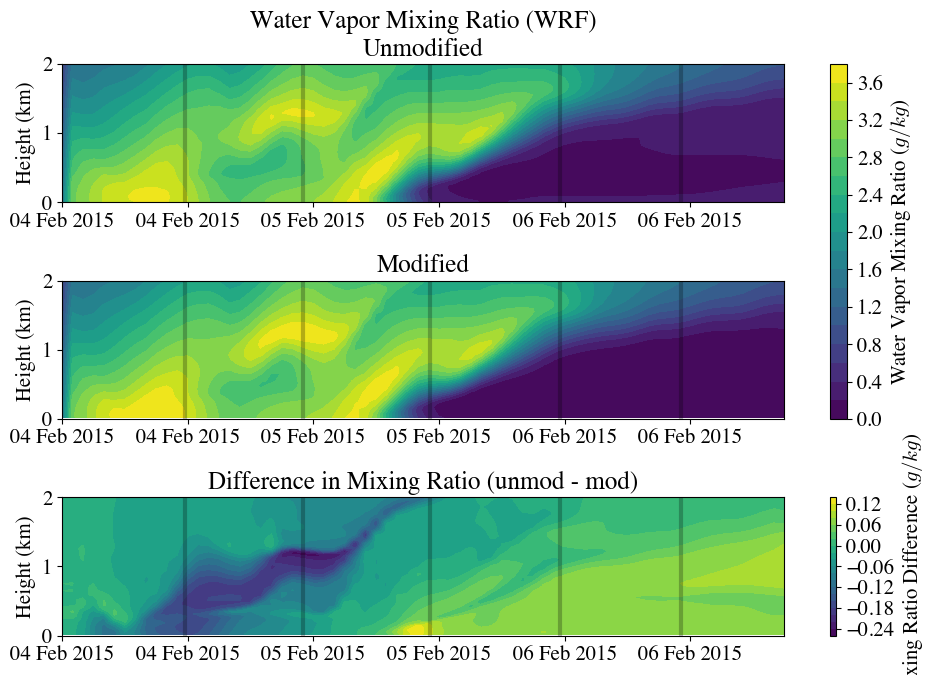

In [10]:
fig, axs = plt.subplots(3, figsize=(10,7))

heatmap = axs[0].contourf(qv_df_mod.index, qv_df.columns / 1000, qv_df.T.values[:,:-1] * 1000, levels = 20)
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Water Vapor Mixing Ratio (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,2)
axs[0].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap = axs[1].contourf(qv_df_mod.index, qv_df_mod.columns / 1000, qv_df_mod.T.values * 1000, levels = 20)
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,2)
axs[1].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap_1 = axs[2].contourf(qv_df_mod.index, qv_df.columns / 1000, 
                            (qv_df.T.values[:,:-1] * 1000) - (qv_df_mod.T.values * 1000), levels = 20)
axs[2].set_ylabel('Height (km)')
axs[2].set_title('Difference in Mixing Ratio (unmod - mod)')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_ylim(0,2)
axs[2].vlines(sounding_ws[sdate:'2015-02-06'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[0:2])
cbar.set_label('Water Vapor Mixing Ratio ($g/kg$)')

cbar = fig.colorbar(heatmap_1, ax=axs[2])
cbar.set_label('Mixing Ratio Difference ($g/kg$)')

plt.show()

## Skin Temperature

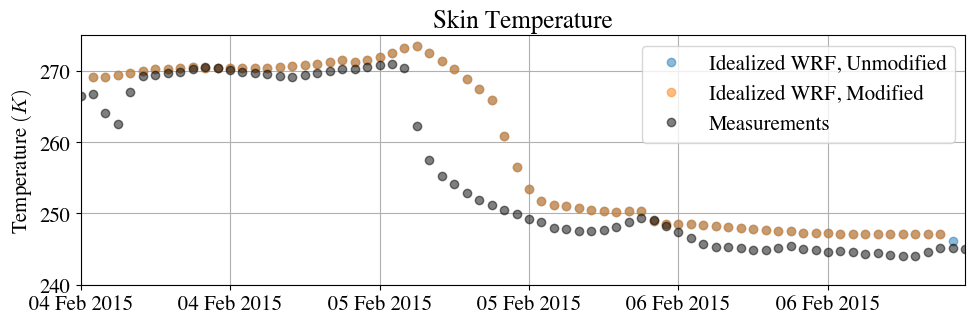

In [11]:
plt.figure(figsize = (10,3.5))

plt.plot(tsk_df, 'o', alpha = 0.5)
plt.plot(tsk_df_mod, 'o', alpha = 0.5)
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.5, color = 'k')
plt.ylabel('Temperature $(K)$')
plt.title('Skin Temperature')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(240,275)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table
Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [12]:
edate = '2015-02-06 21:00:00'
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[sdate:edate]
lwdns['modified'] = lwdnb_df_mod[sdate:edate]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[sdate:edate]
lwups['modified'] = lwupb_df_mod[sdate:edate]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[sdate:edate]
swdns['modified'] = swdnb_df_mod[sdate:edate]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[sdate:edate]
swups['modified'] = swupb_df_mod[sdate:edate]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[sdate:edate]
lhs['modified'] = lh_df_mod[sdate:edate]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[sdate:edate]
shs['modified'] = sh_df_mod[sdate:edate]

In [13]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                        (shs['modified'] - shs['measured']).mean(),
                        (lwdns['modified'] - lwdns['measured']).mean(),
                        (lwups['modified'] - lwups['measured']).mean(),
                        (swdns['modified'] - swdns['measured']).mean(),
                        (swups['modified'] - swups['measured']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_mod.index = ['bias']
mae_mod = pd.DataFrame([(np.abs(lhs['modified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['modified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['modified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['modified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['modified'] - swdns['measured'])).mean(),
                        (np.abs(swups['modified'] - swups['measured'])).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_mod.index = ['mae']
mean_flux_mod = pd.DataFrame([(lhs['modified']).mean(), 
                        (shs['modified']).mean(),
                        (lwdns['modified']).mean(),
                        (lwups['modified']).mean(),
                        (swdns['modified']).mean(),
                        (swups['modified']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_mod.index = ['mean']
mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                        (shs['unmodified'] - shs['measured']).mean(),
                        (lwdns['unmodified'] - lwdns['measured']).mean(),
                        (lwups['unmodified'] - lwups['measured']).mean(),
                        (swdns['unmodified'] - swdns['measured']).mean(),
                        (swups['unmodified'] - swups['measured']).mean()
                        ], 
                        columns = ['original'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_orig.index = ['bias']
mae_orig = pd.DataFrame([(np.abs(lhs['unmodified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['unmodified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['unmodified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['unmodified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['unmodified'] - swdns['measured'])).mean(),
                        (np.abs(swups['unmodified'] - swups['measured'])).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_orig.index = ['mae']
mean_flux_orig = pd.DataFrame([(lhs['unmodified']).mean(), 
                        (shs['unmodified']).mean(),
                        (lwdns['unmodified']).mean(),
                        (lwups['unmodified']).mean(),
                        (swdns['unmodified']).mean(),
                        (swups['unmodified']).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_orig.index = ['mean']
pd.concat([mean_flux_orig, mean_bias_orig, mae_orig]).to_csv('original_case1.csv')
pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]).to_csv('modified_case1.csv')
(pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]) - pd.concat([mean_flux_orig, mean_bias_orig, mae_orig])).to_csv('difference_case1.csv')

In [14]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T
cc_1 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_1 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave
unmodified,0.001947,0.039090,0.788367,0.707233
modified,0.000060,0.065864,0.810590,0.707232


In [15]:
lhs['measured'] - lhs['modified']

2015-02-04 00:00:00     3.861692
2015-02-04 01:00:00     3.077868
2015-02-04 02:00:00     8.235385
2015-02-04 03:00:00    11.017161
2015-02-04 04:00:00    11.076196
                         ...    
2015-02-06 17:00:00   -11.960042
2015-02-06 18:00:00   -11.817080
2015-02-06 19:00:00   -11.315534
2015-02-06 20:00:00   -11.492754
2015-02-06 21:00:00   -11.033403
Freq: H, Length: 70, dtype: float64

In [16]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                                         (shs['modified'] - shs['measured']).mean(),
                                         (lwdns['modified'] - lwdns['measured']).mean(),
                                         (lwups['modified'] - lwups['measured']).mean()
                                         ], 
                                         columns = ['modified'],
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T

mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                                         (shs['unmodified'] - shs['measured']).mean(),
                                         (lwdns['unmodified'] - lwdns['measured']).mean(),
                                         (lwups['unmodified'] - lwups['measured']).mean()
                                         ], 
                                         columns = ['original'],
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T

print(pd.concat([mean_bias_mod, mean_bias_orig]))

             Latent   Sensible  Downwelling Longwave  Upwelling Longwave
modified  11.708545  35.205411             -0.215981            6.464658
original  13.095206  43.502881              2.487758           -1.270988


---
# Case 2 - Spring Cloudy

In [17]:
mean_bias_mod.loc['modified'] - mean_bias_orig.loc['original']

Latent                 -1.386661
Sensible               -8.297469
Downwelling Longwave   -2.703739
Upwelling Longwave      7.735646
dtype: float64

In [18]:
fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case4/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
sdate = '2015-05-02'
edate = '2015-05-04' 

sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

#cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
#cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values).resample('1h').mean()

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values).resample('1h').mean()

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values).resample('1h').mean()

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values).resample('1h').mean()

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values).resample('1h').mean()

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values).resample('1h').mean()

# Finding all wrfout file
fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/2CloudySpring_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

#cldfra_mod = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
#cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod)

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values).resample('1h').mean()

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values).resample('1h').mean()

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values).resample('1h').mean()

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values).resample('1h').mean()

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values).resample('1h').mean()

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values).resample('1h').mean()

In [19]:
wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case4/000101/wrfstat_d01_2015-05-02_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]
qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df = np.sqrt(v_df**2 + u_df**2)
qv_df = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/2CloudySpring_000101/wrfstat_d01_2015-05-02_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]
qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df_mod = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df_mod = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df_mod = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df_mod = np.sqrt(v_df_mod**2 + u_df_mod**2)
qv_df_mod = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df_mod = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

## Clouds

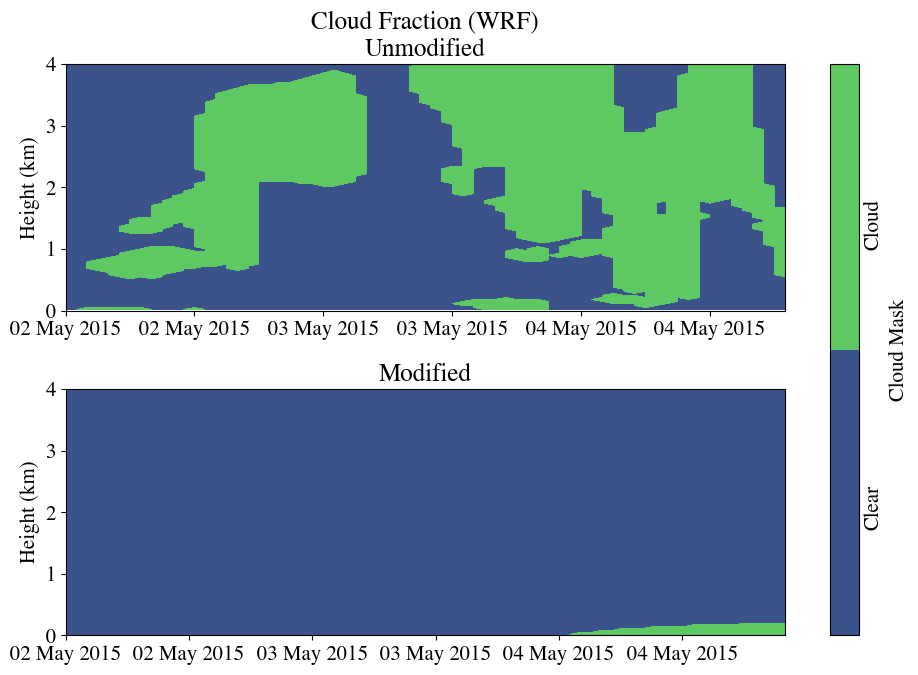

In [20]:
fig, axs = plt.subplots(2, figsize=(10,7))

heatmap = axs[0].contourf(cloudmask_df.index, cloudmask_df.columns / 1000, cloudmask_df.T.values, levels = [-1, 0, 1])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,4)

heatmap = axs[1].contourf(cloudmask_df_mod.index, cloudmask_df_mod.columns / 1000, cloudmask_df_mod.T, levels = [-1, 0, 1])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,4)
plt.tight_layout()

cbar = fig.colorbar(heatmap, ax=axs[:], ticks = [-0.5, 0.5], label = "Cloud Mask")
cbar.ax.set_yticklabels(['Clear','Cloud'], rotation = 90)
cbar.ax.tick_params(size=0)

plt.savefig('cloudfrac_0502.png')

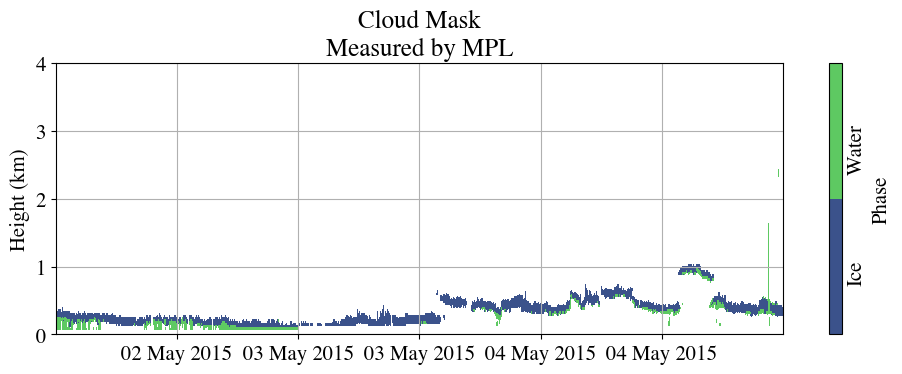

In [21]:
from datetime import datetime 
fns = ['/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150502.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150503.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150504.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns / 1000, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (km)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


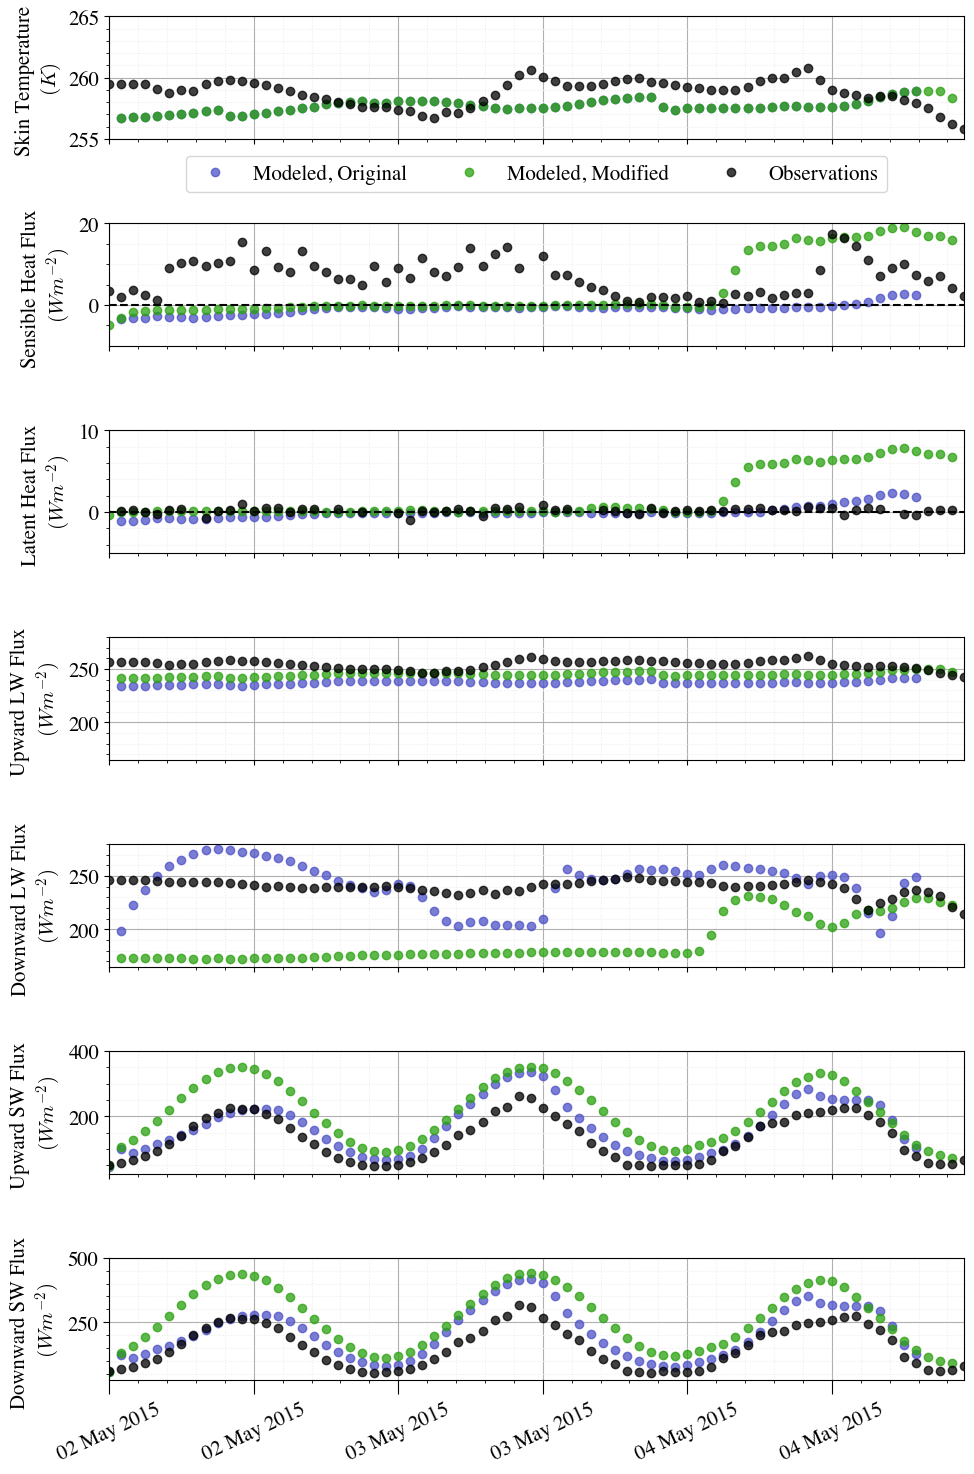

In [22]:
%pylab inline

mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'times'
mpl.rcParams["mathtext.fontset"] = 'cm'

plt.figure(figsize = (10,15))
plt.subplot(711)
plt.plot(tsk_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(tsk_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.75, color = 'k')
plt.ylabel('Skin Temperature \n$(K)$')
plt.grid()
plt.legend(['Modeled, Original', 'Modeled, Modified', 'Observations'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.ylim(255, 265)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(712)
plt.plot(sh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(sh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Sensible Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-10,20)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(713)
plt.plot(lh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Latent Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-5,10)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(715)
plt.plot(lwdnb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_downlw[sdate:edate].index[0], xmax = M_downlw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Downward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(165,280)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(714)
plt.plot(lwupb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwupb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_uplw[sdate:edate].index[0], xmax = M_uplw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Upward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(165,280)
plt.xlim(M_uplw[sdate:edate].index[0],M_uplw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(716)
plt.plot(swupb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(swupb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_upsw[sdate:edate].index[0], xmax = M_upsw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Upward SW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(25,400)
plt.xlim(M_upsw[sdate:edate].index[0],M_upsw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(717)
plt.plot(swdnb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(swdnb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_downsw[sdate:edate].index[0], xmax = M_downsw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Downward SW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(25,500)
plt.xlim(M_downsw[sdate:edate].index[0],M_downsw[sdate:edate].index[-1])
myFmt = DateFormatter("%d %b %Y")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gca().tick_params(axis = 'x', labelrotation = 25, length = 10, labelsize = 15)
plt.gca().tick_params(axis = 'y', length = 4, labelsize = 15)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('case2_all_new.png')

## Longwave and Shortwave Radiation

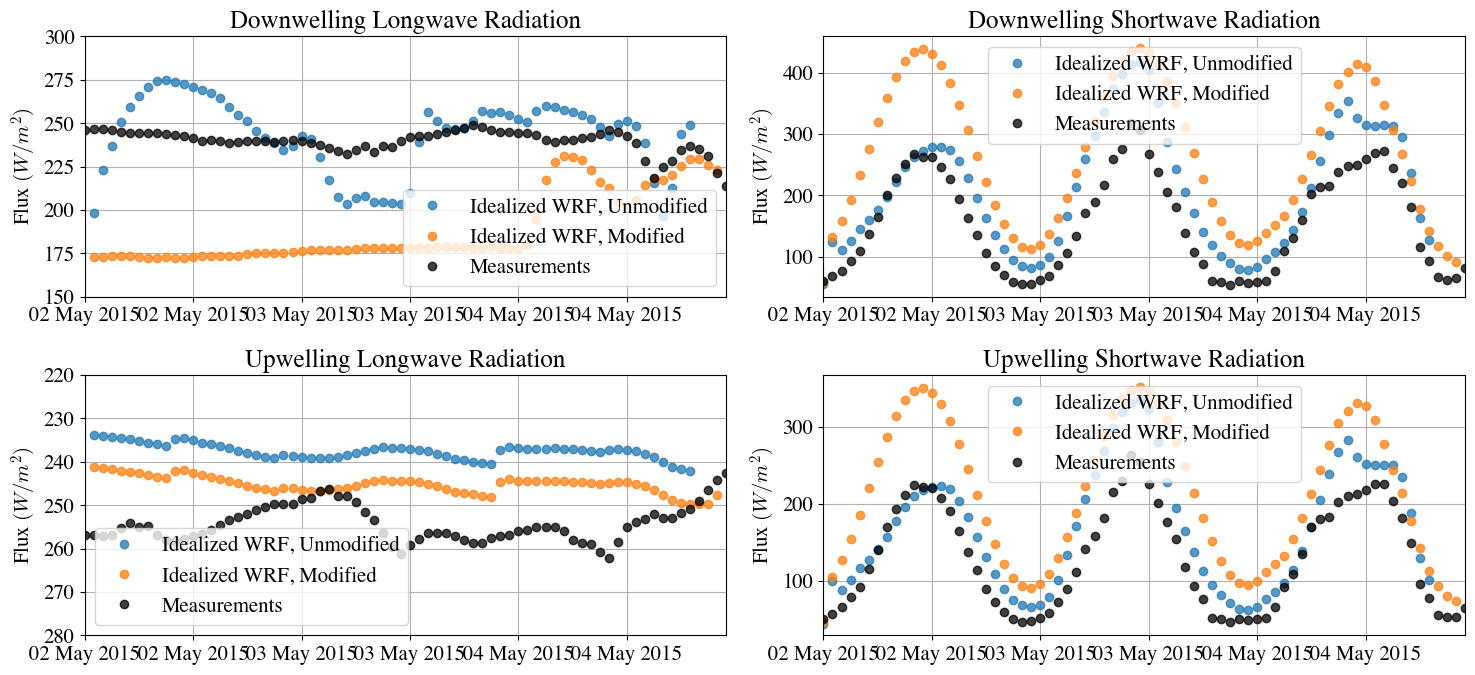

In [23]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(150,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(280,220)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(swdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(swupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Wind Speed

## Moisture

## Skin Temperature

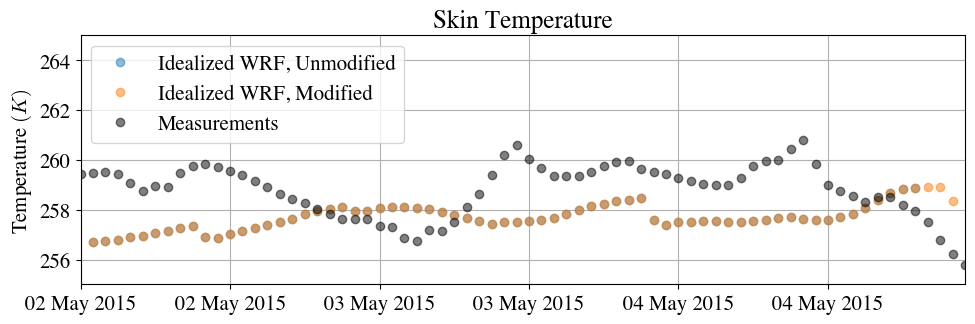

In [24]:
plt.figure(figsize = (10,3.5))
plt.plot(tsk_df, 'o', alpha = 0.5)
plt.plot(tsk_df_mod, 'o', alpha = 0.5)
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.5, color = 'k')
plt.ylabel('Temperature $(K)$')
plt.title('Skin Temperature')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(255,265)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table

Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [25]:
edate = '2015-05-04 19:30:00'
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[sdate:edate]
lwdns['modified'] = lwdnb_df_mod[sdate:edate]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[sdate:edate]
lwups['modified'] = lwupb_df_mod[sdate:edate]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[sdate:edate]
swdns['modified'] = swdnb_df_mod[sdate:edate]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[sdate:edate]
swups['modified'] = swupb_df_mod[sdate:edate]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[sdate:edate]
lhs['modified'] = lh_df_mod[sdate:edate]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[sdate:edate]
shs['modified'] = sh_df_mod[sdate:edate]

In [26]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                        (shs['modified'] - shs['measured']).mean(),
                        (lwdns['modified'] - lwdns['measured']).mean(),
                        (lwups['modified'] - lwups['measured']).mean(),
                        (swdns['modified'] - swdns['measured']).mean(),
                        (swups['modified'] - swups['measured']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_mod.index = ['bias']
mae_mod = pd.DataFrame([(np.abs(lhs['modified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['modified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['modified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['modified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['modified'] - swdns['measured'])).mean(),
                        (np.abs(swups['modified'] - swups['measured'])).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_mod.index = ['mae']
mean_flux_mod = pd.DataFrame([(lhs['modified']).mean(), 
                        (shs['modified']).mean(),
                        (lwdns['modified']).mean(),
                        (lwups['modified']).mean(),
                        (swdns['modified']).mean(),
                        (swups['modified']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_mod.index = ['mean']
mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                        (shs['unmodified'] - shs['measured']).mean(),
                        (lwdns['unmodified'] - lwdns['measured']).mean(),
                        (lwups['unmodified'] - lwups['measured']).mean(),
                        (swdns['unmodified'] - swdns['measured']).mean(),
                        (swups['unmodified'] - swups['measured']).mean()
                        ], 
                        columns = ['original'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_orig.index = ['bias']
mae_orig = pd.DataFrame([(np.abs(lhs['unmodified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['unmodified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['unmodified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['unmodified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['unmodified'] - swdns['measured'])).mean(),
                        (np.abs(swups['unmodified'] - swups['measured'])).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_orig.index = ['mae']
mean_flux_orig = pd.DataFrame([(lhs['unmodified']).mean(), 
                        (shs['unmodified']).mean(),
                        (lwdns['unmodified']).mean(),
                        (lwups['unmodified']).mean(),
                        (swdns['unmodified']).mean(),
                        (swups['unmodified']).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_orig.index = ['mean']
pd.concat([mean_flux_orig, mean_bias_orig, mae_orig]).to_csv('original_case2.csv')
pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]).to_csv('modified_case2.csv')
(pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]) - pd.concat([mean_flux_orig, mean_bias_orig, mae_orig])).to_csv('difference_case2.csv')

In [27]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values,
                                         swdns.corr()['measured'].values,
                                         swups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave', 'Downwelling Shortwave', 'Upwelling Shortwave']).T
cc_2 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_2 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.001058,0.008596,0.108823,0.012839,0.898308,0.895751
modified,0.002069,0.000511,0.132362,0.012839,0.898227,0.907423


In [28]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                                         (shs['modified'] - shs['measured']).mean(),
                                         (lwdns['modified'] - lwdns['measured']).mean(),
                                         (lwups['modified'] - lwups['measured']).mean(),
                                        (swdns['modified'] - swdns['measured']).mean(),
                                        (swups['modified'] - swups['measured']).mean()

                                         ], 
                                         columns = ['modified'],
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T

mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                                         (shs['unmodified'] - shs['measured']).mean(),
                                         (lwdns['unmodified'] - lwdns['measured']).mean(),
                                         (lwups['unmodified'] - lwups['measured']).mean(),
                                        (swdns['unmodified'] - swdns['measured']).mean(),
                                         (swups['unmodified'] - swups['measured']).mean()
                                         ], 
                                         columns = ['original'],
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T

print(pd.concat([mean_bias_mod, mean_bias_orig]))

            Latent  Sensible  Downwelling Longwave  Upwelling Longwave  \
modified  1.580196 -4.198019            -54.832994          -11.693261   
original -0.157001 -9.837973              0.338519          -19.137112   

          Downwelling Shortwave  Upwelling Shortwave  
modified             111.145649            81.963665  
original              50.200083            33.207212  


In [29]:
mean_bias_mod.loc['modified'] - mean_bias_orig.loc['original']

Latent                    1.737197
Sensible                  5.639954
Downwelling Longwave    -55.171513
Upwelling Longwave        7.443851
Downwelling Shortwave    60.945566
Upwelling Shortwave      48.756453
dtype: float64

# Case 3 - Spring Clear

In [30]:
sdate = '2015-05-22'
edate = '2015-05-24' 

M_net = (M_downlw['lw'] - M_uplw['lw'])
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case3/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
#cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
#cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values).resample('1h').mean()

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values).resample('1h').mean()

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values).resample('1h').mean()

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values).resample('1h').mean()

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values).resample('1h').mean()

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values).resample('1h').mean()

# MODIFIED

# Finding all wrfout file
fns = glob('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/3ClearSpring_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

# Importing WRF variables
## dbZ - for cloud plotting
cldfra_mod = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod).resample('1h').mean()

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values).resample('1h').mean()

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values).resample('1h').mean()

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values).resample('1h').mean()

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values).resample('1h').mean()

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values).resample('1h').mean()

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values).resample('1h').mean()

In [31]:
wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/cases/case3/000101/second_try/wrfstat_d01_2015-05-22_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]
qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df = np.sqrt(v_df**2 + u_df**2)
qv_df = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()


wrfstat = xr.open_dataset('/Volumes/Seagate Desktop/PhD Data/WRF/ideal/landusetbl_modifications/3ClearSpring_000101/corrected_input/wrfstat_d01_2015-05-22_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_tsk = wrfstat['CST_TSK']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
csp_u = wrfstat['CSP_U']
csp_v = wrfstat['CSP_V']
csv_qv = wrfstat["CSP_QV"]
qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
sh_df_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['sh']).resample('1h').mean()
lh_df_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['lh']).resample('1h').mean()
tsk_df_mod = pd.DataFrame(cst_tsk.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['tsk']).resample('1h').mean()
u_df_mod = pd.DataFrame(csp_u.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
v_df_mod = pd.DataFrame(csp_v.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()
ws_df_mod = np.sqrt(v_df_mod**2 + u_df_mod**2)
qv_df_mod = pd.DataFrame(csv_qv.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

cloudmask = wrfstat['CSV_CLDFRAC'].isel(south_north = round(len(wrfstat.south_north) / 2), west_east = round(len(wrfstat.west_east) / 2))
cloudmask_df_mod = pd.DataFrame(cloudmask.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values).resample('1h').mean()

## Clouds

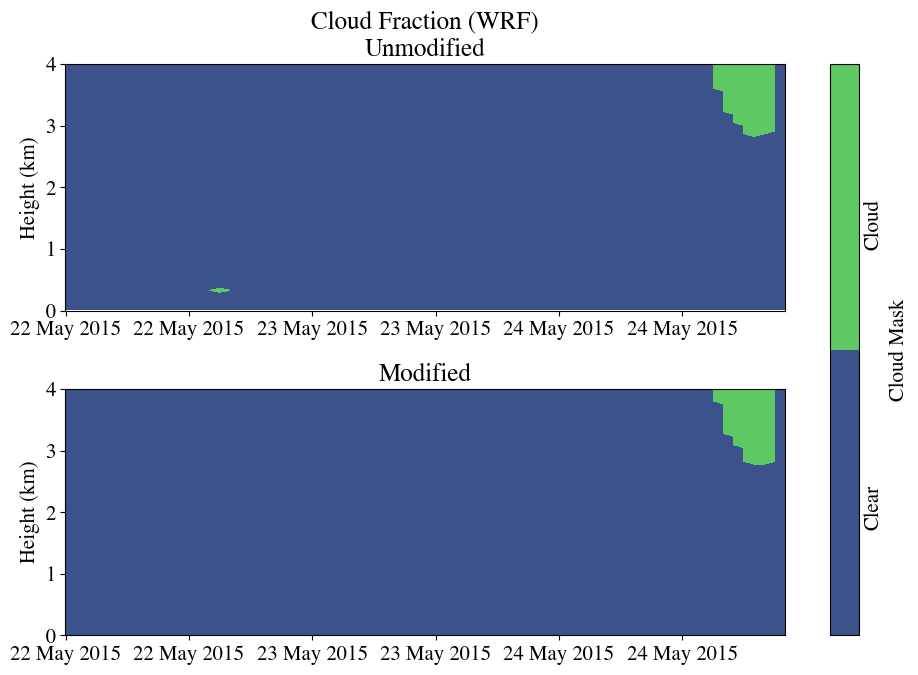

In [32]:
fig, axs = plt.subplots(2, figsize=(10,7))

heatmap = axs[0].contourf(cloudmask_df.index, cloudmask_df.columns / 1000, cloudmask_df.T.values, levels = [-1, 0, 1])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,4)

heatmap = axs[1].contourf(cloudmask_df_mod.index, cloudmask_df_mod.columns / 1000, cloudmask_df_mod.T, levels = [-1, 0, 1])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,4)
plt.tight_layout()

cbar = fig.colorbar(heatmap, ax=axs[:], ticks = [-0.5, 0.5], label = "Cloud Mask")
cbar.ax.set_yticklabels(['Clear','Cloud'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.show()

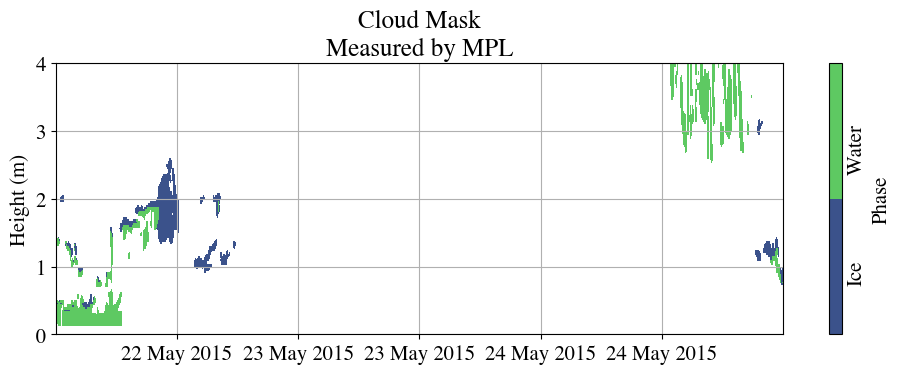

In [33]:
from datetime import datetime
fns = ['/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150522.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150523.cdf',
       '/Volumes/Seagate Desktop/PhD Data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150524.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns / 1000, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (m)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


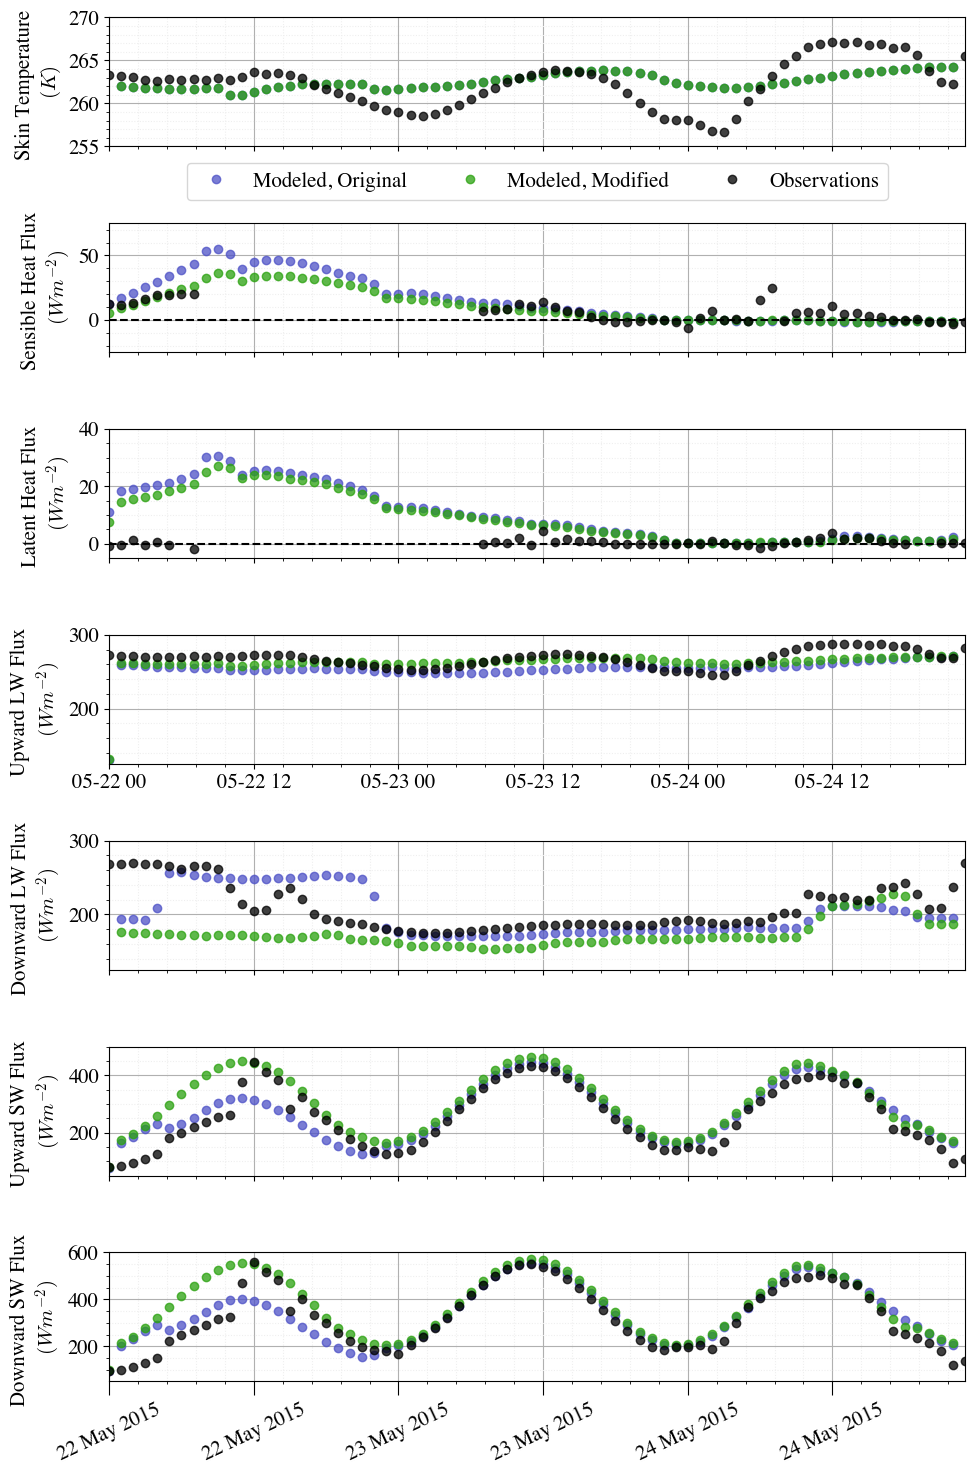

In [34]:
%pylab inline

mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'times'
mpl.rcParams["mathtext.fontset"] = 'cm'

plt.figure(figsize = (10,15))
plt.subplot(711)
plt.plot(tsk_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(tsk_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.75, color = 'k')
plt.ylabel('Skin Temperature \n$(K)$')
plt.grid()
plt.legend(['Modeled, Original', 'Modeled, Modified', 'Observations'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.ylim(255,270)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(712)
plt.plot(sh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(sh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Sensible Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-25,75)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(713)
plt.plot(lh_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lh_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Latent Heat Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(-5,40)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(715)
plt.plot(lwdnb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_downlw[sdate:edate].index[0], xmax = M_downlw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Downward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(125,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(714)
plt.plot(lwupb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(lwupb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_uplw[sdate:edate].index[0], xmax = M_uplw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Upward LW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(125,300)
plt.xlim(M_uplw[sdate:edate].index[0],M_uplw[sdate:edate].index[-1])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(716)
plt.plot(swupb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(swupb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_upsw[sdate:edate].index[0], xmax = M_upsw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Upward SW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(50,500)
plt.xlim(M_upsw[sdate:edate].index[0],M_upsw[sdate:edate].index[-1])
plt.gca().xaxis.set_ticklabels([])
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()

plt.subplot(717)
plt.plot(swdnb_df, 'o', alpha = 0.75, color = '#4D51C6')
plt.plot(swdnb_df_mod, 'o', alpha = 0.75, color = '#2aa10f')
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_downsw[sdate:edate].index[0], xmax = M_downsw[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Downward SW Flux \n$(Wm^{-2})$')
plt.grid()
plt.ylim(50,600)
plt.xlim(M_downsw[sdate:edate].index[0],M_downsw[sdate:edate].index[-1])
myFmt = DateFormatter("%d %b %Y")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gca().tick_params(axis = 'x', labelrotation = 25, length = 10, labelsize = 15)
plt.gca().tick_params(axis = 'y', length = 4, labelsize = 15)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('case3_all_new.png')

## Longwave and Shortwave Radiation

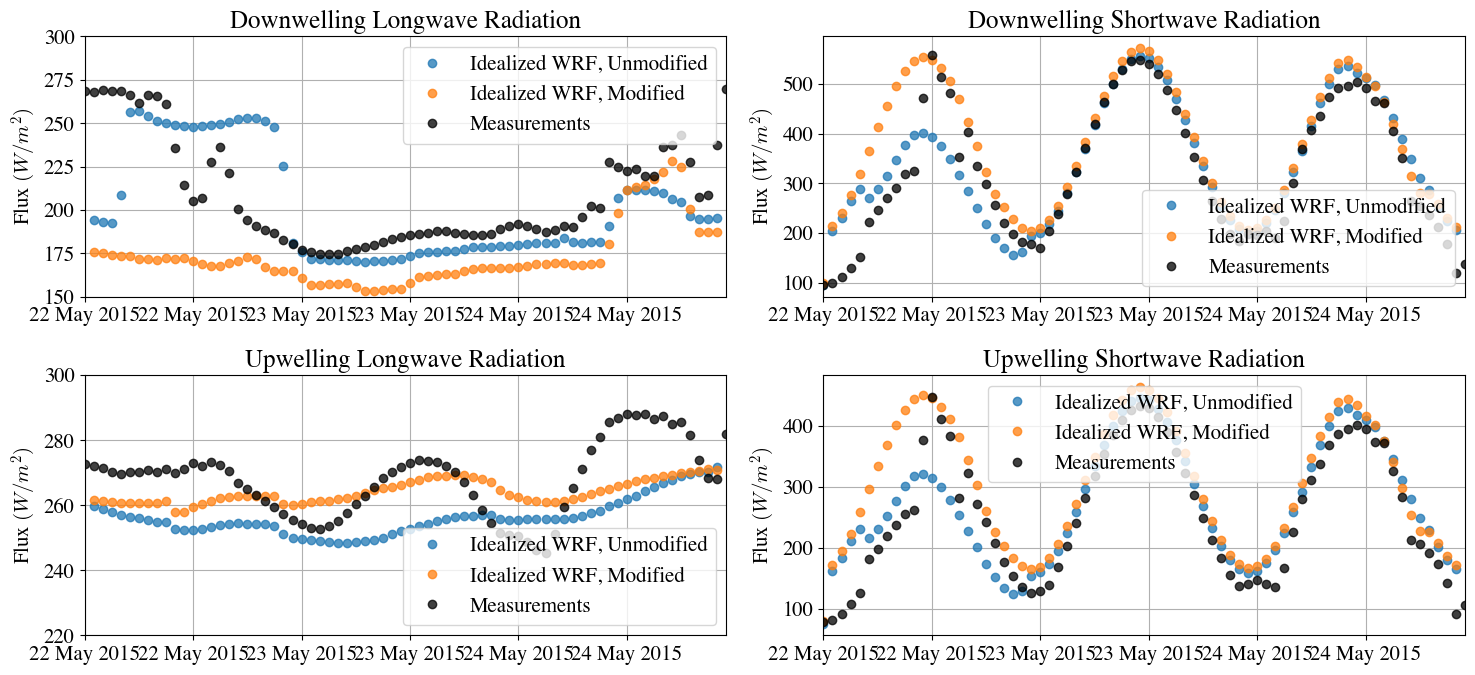

In [35]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(150,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(220,300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(swdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(swupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Wind Speed

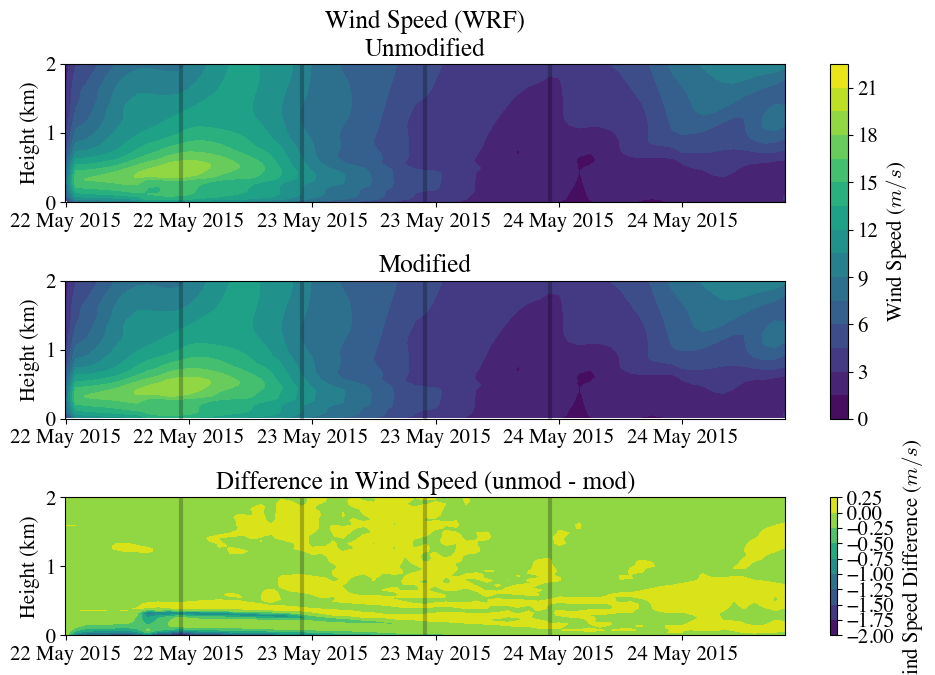

In [36]:
fig, axs = plt.subplots(3, figsize=(10,7))

heatmap = axs[0].contourf(ws_df.index, ws_df.columns / 1000, ws_df.T.values, levels = 20)
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Wind Speed (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,2)
axs[0].vlines(sounding_ws[sdate:'2015-05-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap = axs[1].contourf(ws_df_mod.index, ws_df_mod.columns / 1000, ws_df_mod.T.values, levels = 20)
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,2)
axs[1].vlines(sounding_ws[sdate:'2015-05-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap_1 = axs[2].contourf(ws_df.index, ws_df.columns / 1000, ws_df.T.values - ws_df_mod.T.values)
axs[2].set_ylabel('Height (km)')
axs[2].set_title('Difference in Wind Speed (unmod - mod)')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_ylim(0,2)
axs[2].vlines(sounding_ws[sdate:'2015-05-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[0:2])
cbar.set_label('Wind Speed ($m/s$)')

cbar = fig.colorbar(heatmap_1, ax=axs[2])
cbar.set_label('Wind Speed Difference ($m/s$)')

plt.show()

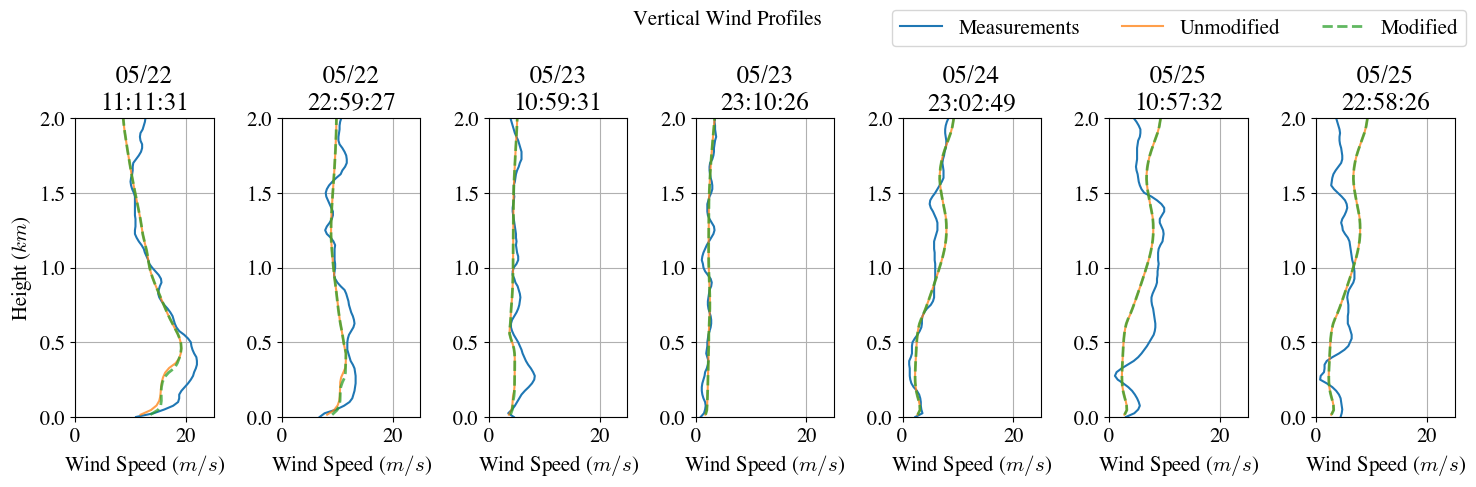

In [37]:
dates = sounding_ws[sdate:'2015-05-25'].index
fig, axs = plt.subplots(ncols = len(dates), figsize=(15,5))

for i in np.arange(0, len(dates), 1):
    prof = axs[i].plot(sounding_ws.loc[dates[i]], sounding_ws.loc[dates[i]].index / 1000, label = 'Measurements')
    axs[i].set_ylim(0, 2)
    axs[i].grid()
    axs[i].set_xlim(0, 25)
    axs[i].set_xlabel('Wind Speed ($m/s$)')
    axs[i].set_title(dates[i].strftime('%m/%d') + '\n' + dates[i].strftime('%H:%M:%S'))
    
    axs[i].plot(ws_df.iloc[ws_df.index.get_loc(dates[i], method = 'nearest')], 
                ws_df.iloc[ws_df.index.get_loc(dates[0], method = 'nearest')].index / 1000, 
                label = 'Unmodified', alpha = 0.75)
    axs[i].plot(ws_df_mod.iloc[ws_df_mod.index.get_loc(dates[i], method = 'nearest')], 
                ws_df_mod.iloc[ws_df_mod.index.get_loc(dates[0], method = 'nearest')].index / 1000, 
                '--', label = 'Modified', alpha = 0.75, lw = 2)

axs[0].set_ylabel('Height ($km$)')
plt.suptitle('Vertical Wind Profiles', fontsize = 15)
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol = 3)

plt.show()

## Moisture

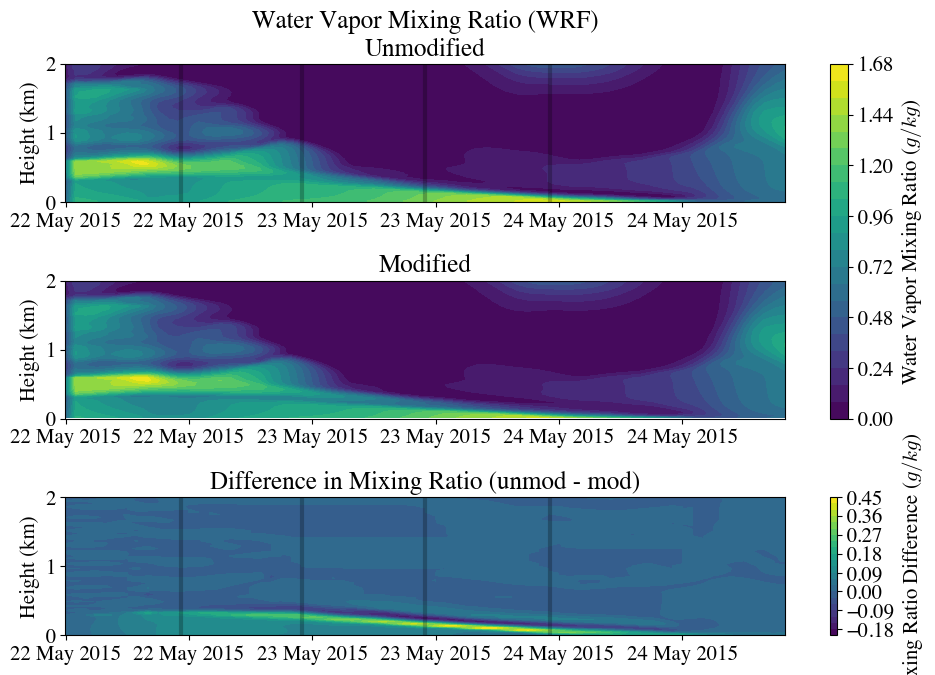

In [38]:
fig, axs = plt.subplots(3, figsize=(10,7))

heatmap = axs[0].contourf(qv_df_mod.index, qv_df.columns / 1000, qv_df.T.values * 1000, levels = 20)
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Water Vapor Mixing Ratio (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,2)
axs[0].vlines(sounding_ws[sdate:'2015-05-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap = axs[1].contourf(qv_df_mod.index, qv_df_mod.columns / 1000, qv_df_mod.T.values * 1000, levels = 20)
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylim(0,2)
axs[1].vlines(sounding_ws[sdate:'2015-02-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

heatmap_1 = axs[2].contourf(qv_df_mod.index, qv_df.columns / 1000, 
                            (qv_df.T.values * 1000) - (qv_df_mod.T.values * 1000), levels = 20)
axs[2].set_ylabel('Height (km)')
axs[2].set_title('Difference in Mixing Ratio (unmod - mod)')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_ylim(0,2)
axs[2].vlines(sounding_ws[sdate:'2015-05-24'].index, 0, 2, color = 'k', alpha = 0.25, lw = 3)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[0:2])
cbar.set_label('Water Vapor Mixing Ratio ($g/kg$)')

cbar = fig.colorbar(heatmap_1, ax=axs[2])
cbar.set_label('Mixing Ratio Difference ($g/kg$)')

plt.show()

## Temperature

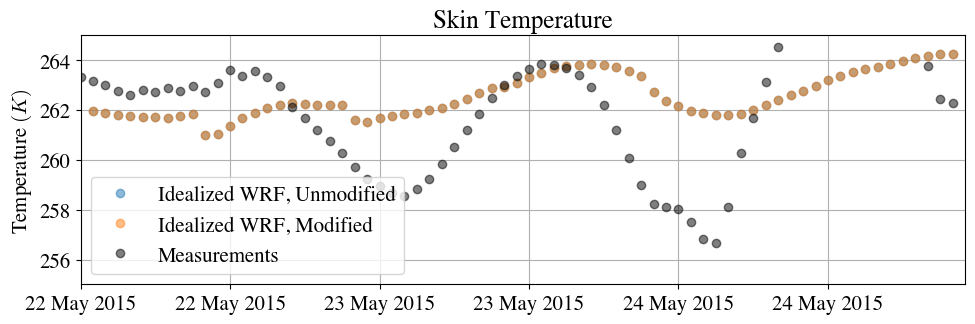

In [39]:
plt.figure(figsize = (10,3.5))
plt.plot(tsk_df, 'o', alpha = 0.5)
plt.plot(tsk_df_mod, 'o', alpha = 0.5)
plt.plot(T_meas[sdate:edate].resample('30min').first(), 'o', alpha = 0.5, color = 'k')
plt.ylabel('Temperature $(K)$')
plt.title('Skin Temperature')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(255,265)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

# Summary Table
Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [40]:
edate = '2015-05-24 22:30:00'
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[sdate:edate]
lwdns['modified'] = lwdnb_df_mod[sdate:edate]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[sdate:edate]
lwups['modified'] = lwupb_df_mod[sdate:edate]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[sdate:edate]
swdns['modified'] = swdnb_df_mod[sdate:edate]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[sdate:edate]
swups['modified'] = swupb_df_mod[sdate:edate]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[sdate:edate]
lhs['modified'] = lh_df_mod[sdate:edate]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[sdate:edate]
shs['modified'] = sh_df_mod[sdate:edate]

In [41]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                        (shs['modified'] - shs['measured']).mean(),
                        (lwdns['modified'] - lwdns['measured']).mean(),
                        (lwups['modified'] - lwups['measured']).mean(),
                        (swdns['modified'] - swdns['measured']).mean(),
                        (swups['modified'] - swups['measured']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_mod.index = ['bias']
mae_mod = pd.DataFrame([(np.abs(lhs['modified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['modified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['modified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['modified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['modified'] - swdns['measured'])).mean(),
                        (np.abs(swups['modified'] - swups['measured'])).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_mod.index = ['mae']
mean_flux_mod = pd.DataFrame([(lhs['modified']).mean(), 
                        (shs['modified']).mean(),
                        (lwdns['modified']).mean(),
                        (lwups['modified']).mean(),
                        (swdns['modified']).mean(),
                        (swups['modified']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_mod.index = ['mean']
mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                        (shs['unmodified'] - shs['measured']).mean(),
                        (lwdns['unmodified'] - lwdns['measured']).mean(),
                        (lwups['unmodified'] - lwups['measured']).mean(),
                        (swdns['unmodified'] - swdns['measured']).mean(),
                        (swups['unmodified'] - swups['measured']).mean()
                        ], 
                        columns = ['original'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_orig.index = ['bias']
mae_orig = pd.DataFrame([(np.abs(lhs['unmodified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['unmodified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['unmodified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['unmodified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['unmodified'] - swdns['measured'])).mean(),
                        (np.abs(swups['unmodified'] - swups['measured'])).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_orig.index = ['mae']
mean_flux_orig = pd.DataFrame([(lhs['unmodified']).mean(), 
                        (shs['unmodified']).mean(),
                        (lwdns['unmodified']).mean(),
                        (lwups['unmodified']).mean(),
                        (swdns['unmodified']).mean(),
                        (swups['unmodified']).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_orig.index = ['mean']
pd.concat([mean_flux_orig, mean_bias_orig, mae_orig]).to_csv('original_case3.csv')
pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]).to_csv('modified_case3.csv')
(pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]) - pd.concat([mean_flux_orig, mean_bias_orig, mae_orig])).to_csv('difference_case3.csv')

In [42]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values,
                                         swdns.corr()['measured'].values,
                                         swups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave', 'Downwelling Shortwave', 'Upwelling Shortwave']).T
cc_3 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_3 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.034531,0.512364,0.163834,0.022490,0.823356,0.823721
modified,0.034096,0.497659,0.090294,0.002197,0.841708,0.860791


In [43]:
mean_bias_mod = pd.DataFrame([(lhs['modified'] - lhs['measured']).mean(), 
                        (shs['modified'] - shs['measured']).mean(),
                        (lwdns['modified'] - lwdns['measured']).mean(),
                        (lwups['modified'] - lwups['measured']).mean(),
                        (swdns['modified'] - swdns['measured']).mean(),
                        (swups['modified'] - swups['measured']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_mod.index = ['bias']
mae_mod = pd.DataFrame([(np.abs(lhs['modified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['modified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['modified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['modified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['modified'] - swdns['measured'])).mean(),
                        (np.abs(swups['modified'] - swups['measured'])).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_mod.index = ['mae']
mean_flux_mod = pd.DataFrame([(lhs['modified']).mean(), 
                        (shs['modified']).mean(),
                        (lwdns['modified']).mean(),
                        (lwups['modified']).mean(),
                        (swdns['modified']).mean(),
                        (swups['modified']).mean()], 
                        columns = ['modified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_mod.index = ['mean']
mean_bias_orig = pd.DataFrame([(lhs['unmodified'] - lhs['measured']).mean(), 
                        (shs['unmodified'] - shs['measured']).mean(),
                        (lwdns['unmodified'] - lwdns['measured']).mean(),
                        (lwups['unmodified'] - lwups['measured']).mean(),
                        (swdns['unmodified'] - swdns['measured']).mean(),
                        (swups['unmodified'] - swups['measured']).mean()
                        ], 
                        columns = ['original'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_bias_orig.index = ['bias']
mae_orig = pd.DataFrame([(np.abs(lhs['unmodified'] - lhs['measured'])).mean(), 
                        (np.abs(shs['unmodified'] - shs['measured'])).mean(),
                        (np.abs(lwdns['unmodified'] - lwdns['measured'])).mean(),
                        (np.abs(lwups['unmodified'] - lwups['measured'])).mean(),
                        (np.abs(swdns['unmodified'] - swdns['measured'])).mean(),
                        (np.abs(swups['unmodified'] - swups['measured'])).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mae_orig.index = ['mae']
mean_flux_orig = pd.DataFrame([(lhs['unmodified']).mean(), 
                        (shs['unmodified']).mean(),
                        (lwdns['unmodified']).mean(),
                        (lwups['unmodified']).mean(),
                        (swdns['unmodified']).mean(),
                        (swups['unmodified']).mean()], 
                        columns = ['unmodified'],
                        index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave','Downwelling Shortwave', 'Upwelling Shortwave']).T
mean_flux_orig.index = ['mean']
pd.concat([mean_flux_orig, mean_bias_orig, mae_orig]).to_csv('original_case3.csv')
pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]).to_csv('modified_case3.csv')
(pd.concat([mean_flux_mod, mean_bias_mod, mae_mod]) - pd.concat([mean_flux_orig, mean_bias_orig, mae_orig])).to_csv('difference_case3.csv')

## Statistics and Summary

In [44]:
mean_cc = (cc_3.iloc[:,0:4] + cc_2.iloc[:,0:4] + cc_1)/3
mean_cc_sw = ((cc_3.iloc[:,4:6] + cc_2.iloc[:,4:6])/2)
mean_cc = pd.concat([mean_cc, mean_cc_sw])

mean_rs = (rs_3.iloc[:,0:4] + rs_2.iloc[:,0:4] + rs_1)/3
mean_rs_sw = ((rs_3.iloc[:,4:6] + rs_2.iloc[:,4:6])/2)
mean_rs = pd.concat([mean_rs, mean_rs_sw], axis=1, join="inner")

mean_rs[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.012512,0.186683,0.353675,0.247521,0.860832,0.859736
modified,0.012075,0.188011,0.344415,0.240756,0.869967,0.884107


In [45]:
mean_rs.loc['modified'] - mean_rs.loc['unmodified']

Latent                  -0.000437
Sensible                 0.001328
Downwelling Longwave    -0.009259
Upwelling Longwave      -0.006765
Downwelling Shortwave    0.009136
Upwelling Shortwave      0.024371
dtype: float64